Number of stars: 2


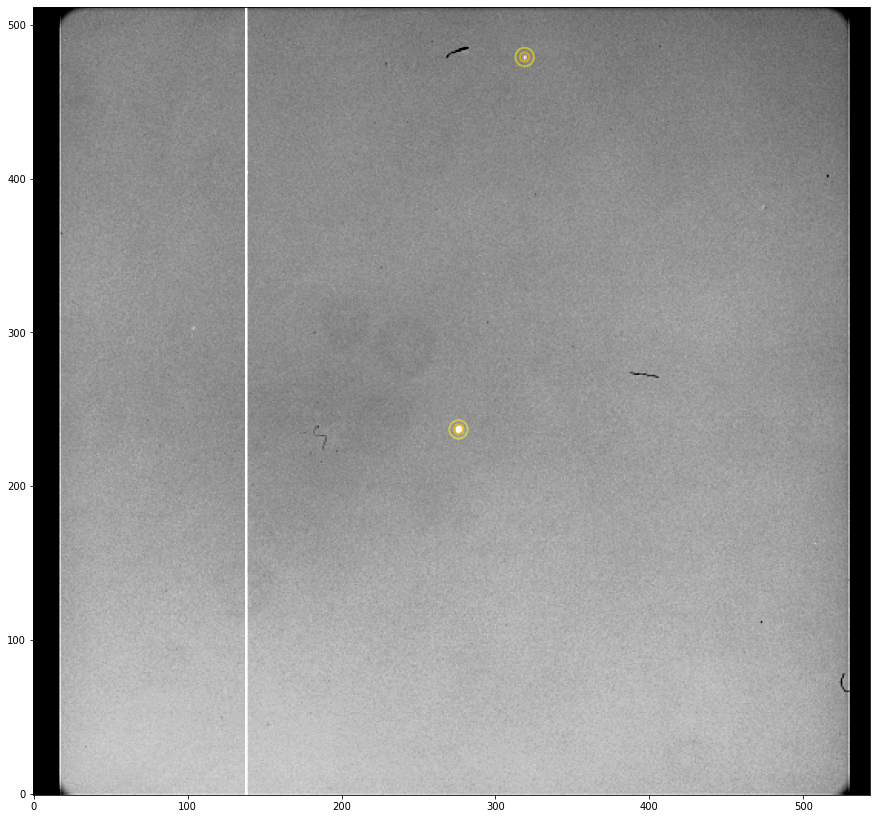

In [7]:
import numpy as np
from astropy.io import fits 
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.visualization import ZScaleInterval,  ImageNormalize
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture, ApertureStats
import matplotlib
import matplotlib.pyplot as plt

## Aperture Setup 
#We need to setup the aperture and annulus radii appropriately before we can compute photometry. 

############################ Variable Parameters #####################################
# Please feel free to change these to get an aperture you feel is appropriate 

arad = 3.                               # aperture radius in pixels 
rin = 1*arad                           # annulus inner radius in pixels 
rout = 2*arad                         # annulus outer radius in pixels 

######################################################################################


star_pixel_ds9 = [(276,237),(319 ,479)]    


first_filenum=470
last_filenum=1178

# We would like to check that the apertures are reasonably placed 
# Here we load the first image and overlay the apertures  
filename = './test.' + str(first_filenum) + '.fit'
data = fits.open(filename)


pixels=star_pixel_ds9
nstars=len(pixels)
print("Number of stars:",nstars)

# Now we setup the apertures at these positions using the varialbe parameters above
# Each aperture is central aperture with an annulus surrounding it. 
aperture = CircularAperture(pixels, r=arad)
annulus_aperture = CircularAnnulus(pixels, r_in=rin, r_out=rout)
apers = [aperture, annulus_aperture]

# Figure 1: Aperture setup
# Check that the apertures are reasonably placed 
# Please provide this in your lab submission. 
plt.figure(figsize = (15,15))
norm = ImageNormalize(data[0].data, interval=ZScaleInterval()) #,stretch=SqrtStretch())
plt.imshow(data[0].data, origin = 'lower', cmap = 'Greys_r', norm=norm)
aperture.plot(color='red', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='yellow', lw=2, alpha=0.5)
plt.show()

In [17]:
# arrays for storing flux calculation 

airmass = []

julian_date = []
nfiles=(last_filenum-first_filenum)+1
arr=np.zeros((nstars,nfiles))
pixels = star_pixel_ds9

# Loop through all images from first_filenum to last_filenum in the current directory 
# If you do not have the images saved in the same directory as the notebook, change the path
directory = './'

for i in np.arange(nfiles): 
    # open each fits file 
    filename = directory + 'test.' + str(i+first_filenum) + '.fit'
    data = fits.open(filename)

    # get the header and save the julian date
    hdr = data[0].header
    julian_date.append(hdr['JD'])
    airmass.append(hdr['AIRMASS'])

    # setup aperture (central and annulus) using the values we determined above
    aperture = CircularAperture(pixels, r=arad)
    annulus_aperture = CircularAnnulus(pixels, r_in=rin, r_out=rout)
    apers = [aperture, annulus_aperture]

    # extract photometry at each aperture using photutils 
    # fill in your code here ...
    napers=4
    phot_table = aperture_photometry(data[0].data, apers)
    aperstats=ApertureStats(data[0].data,aperture)

    # Save the aperture flux minus the equivalent background flux in the aperture area
    for j in np.arange(nstars):
        arr[j,i]=phot_table['aperture_sum_0'][j]-phot_table['aperture_sum_1'][j]*aperture.area/annulus_aperture.area

    # update pixels based on xcentroid,ycentroid from last     
    pixels=[(aperstats.xcentroid[0],aperstats.ycentroid[0])]
    for j in np.arange(nstars-1):
        pixels.append((aperstats.xcentroid[j+1],aperstats.ycentroid[j+1]))
n = 0
i = 0
truth = 1
while n < nfiles: 
    if i//30 == 1:
        i = 0
        truth = not(truth)
    i += 1
    if truth:
        print(n, "aardvark")
    else:
        print(n, "chevrolet")
    n+=1



0 aardvark
1 aardvark
2 aardvark
3 aardvark
4 aardvark
5 aardvark
6 aardvark
7 aardvark
8 aardvark
9 aardvark
10 aardvark
11 aardvark
12 aardvark
13 aardvark
14 aardvark
15 aardvark
16 aardvark
17 aardvark
18 aardvark
19 aardvark
20 aardvark
21 aardvark
22 aardvark
23 aardvark
24 aardvark
25 aardvark
26 aardvark
27 aardvark
28 aardvark
29 aardvark
30 chevrolet
31 chevrolet
32 chevrolet
33 chevrolet
34 chevrolet
35 chevrolet
36 chevrolet
37 chevrolet
38 chevrolet
39 chevrolet
40 chevrolet
41 chevrolet
42 chevrolet
43 chevrolet
44 chevrolet
45 chevrolet
46 chevrolet
47 chevrolet
48 chevrolet
49 chevrolet
50 chevrolet
51 chevrolet
52 chevrolet
53 chevrolet
54 chevrolet
55 chevrolet
56 chevrolet
57 chevrolet
58 chevrolet
59 chevrolet
60 aardvark
61 aardvark
62 aardvark
63 aardvark
64 aardvark
65 aardvark
66 aardvark
67 aardvark
68 aardvark
69 aardvark
70 aardvark
71 aardvark
72 aardvark
73 aardvark
74 aardvark
75 aardvark
76 aardvark
77 aardvark
78 aardvark
79 aardvark
80 aardvark
81 aardv

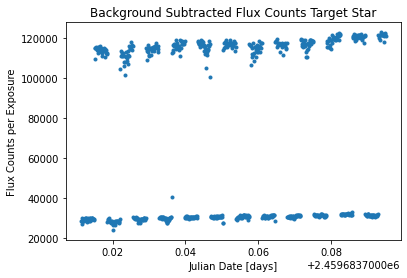

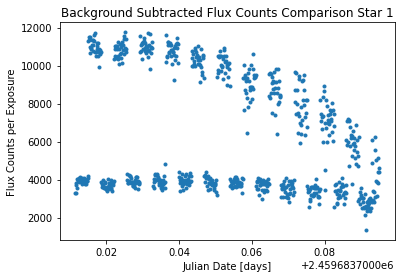

In [9]:
# Figure 3: Plot the light curve for the main star and calibration stars (label your axes, title the plot, use legends)
# Background Subtracted Flux vs. Julian Date 




# If all stars look reasonable, you might normalize their flux (divide by a median value) 

for i in np.arange(nstars):
    plt.plot(julian_date,arr[i],'.')
    if i==0:
        plt.title('Background Subtracted Flux Counts Target Star')
    else:
        plt.title('Background Subtracted Flux Counts Comparison Star '+str(i))    
    plt.xlabel('Julian Date [days]')
    plt.ylabel('Flux Counts per Exposure')
    plt.show()
